# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.


In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import time
import os
import cv2
import sys

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Tensorflow Version: 1.13.1
Keras Version: 2.2.4-tf


Progressbar function

In [2]:
def update_progress(progress, custom=""):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = custom + "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, end="\r")

### Sequential model
In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

In [3]:
# Layer 1
Conv2DLayer1 = layers.Conv2D(input_shape = (101,101,1),
                             filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005)) 

ActivationLayer1 = layers.Activation("tanh")

NormalizationLayer1 = layers.BatchNormalization()

PoolingLayer1 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")

# Layer 2
Conv2DLayer2 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer2 = layers.Activation("tanh")

NormalizationLayer2 = layers.BatchNormalization()

PoolingLayer2 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 3
Conv2DLayer3 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer3 = layers.Activation("tanh")

NormalizationLayer3 = layers.BatchNormalization()

PoolingLayer3 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 4
Conv2DLayer4 = layers.Conv2D(filters = 32,
                             kernel_size = (3,3),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer4 = layers.Activation("tanh")

NormalizationLayer4 = layers.BatchNormalization()

PoolingLayer4 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Fully Connected Layer
FlattenLayer5 = layers.Flatten()
#DenseLayer5 = layers.Dense(200, kernel_initializer = "glorot_uniform")
DenseLayer5 = layers.Dense(130, kernel_initializer = "glorot_uniform")
ActivationLayer5 = layers.Activation("tanh")
NormalizationLayer5 = layers.BatchNormalization()

# Softmax Classifier
DenseLayer6 = layers.Dense(3)
ActivationLayer6 = layers.Activation("softmax")

model_architecture = [
         Conv2DLayer1,
         ActivationLayer1,
         NormalizationLayer1,
         PoolingLayer1,
         
         Conv2DLayer2,
         ActivationLayer2,
         NormalizationLayer2,
         PoolingLayer2,
         
#         Conv2DLayer3,
#         ActivationLayer3,
#         NormalizationLayer3,
#         PoolingLayer3,
         
#         Conv2DLayer4,
#         ActivationLayer4,
#         NormalizationLayer4,
#         PoolingLayer4,
         
         FlattenLayer5,
         DenseLayer5,
         ActivationLayer5,
         NormalizationLayer5,
         
         DenseLayer6,
         ActivationLayer6]

model = tf.keras.Sequential(model_architecture)

### Prints a summary representation of the model

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        544       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 46, 46, 32)        128       
__________

### Plot a graph of the model and save it to a file

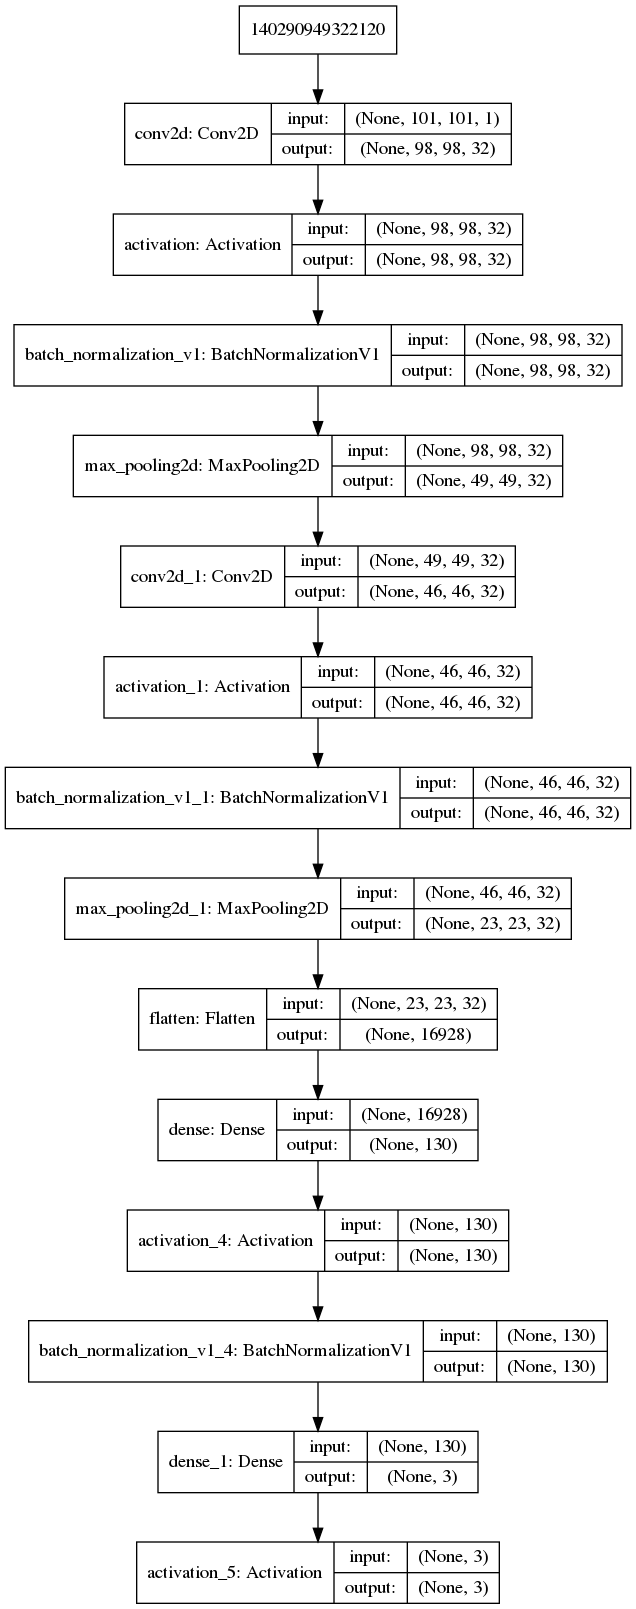

In [5]:
utils.plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'plots/model.png')
Image(retina = True, filename = 'plots/model.png')

## Set up Training

Arguments for Training, that we need to set are:
* The path to the input dataset.
* The number of epochs to train for.
* Path for Our loss/accuracy plot, that will be output to disk
* etc.

In [6]:
MODEL_NAME = "corridor"
DATASET_PATH = os.getcwd() + "/dataset/corridor"
VALIDATION_PATH = DATASET_PATH + "/validation"
TRAIN_PATH = DATASET_PATH + "/train"
TRAIN_EVAL_PLOT_PATH = os.getcwd() + "/plots"

DATASET_PATH_MODIFIED =  os.getcwd() + "/dataset/corridor_m"
VALIDATION_PATH_MODIFIED = DATASET_PATH_MODIFIED + "/validation"
TRAIN_PATH_MODIFIED = DATASET_PATH_MODIFIED + "/train"

NUMBER_OF_EPOCHS = 300
BATCH_SIZE = 64
INIT_LEARNING_RATE = 1e-4
DECAY_LEARNING_RATE = 1e-4 / NUMBER_OF_EPOCHS

HORIZONTAL_FLIP = 1

Here we can see the dataset structure:

+ dataset / corridor
    
    - validation
        - left (X Files)
        - forward (X Files)
        - right (X Files)
    - train
        - left (X Files)
        - forward (X Files)
        - right (X Files)

Initialize the set of labels from dataset we are going to train our network on.

In [7]:
LABELS = list(["left","forward","right"])

Genrate a list of image pathes for our training

In [8]:
train_image_paths = list(paths.list_images(TRAIN_PATH))
validation_image_paths = list(paths.list_images(VALIDATION_PATH))

print("Size of the train-dataset: " + str(len(train_image_paths)))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the train-dataset: 30914
Size of the validation-dataset: 15305


Load default dataset and create a new one with data augemtation. Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images.

In [9]:
i = 0.0
for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)[212:906, 468:1399]
    image = cv2.resize(image, (101, 101))
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + label + '/' + filename, image)

In [10]:
train_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED))

In [11]:
i = 0.0
for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 'right'
    elif label == 'right':
        label = 'left'
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.flip(cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE), HORIZONTAL_FLIP)
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + label + '/f' + filename, image)

Create some images that simulate a wall over the half picture.

In [12]:
forward_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED + '/' + 'forward'))

In [13]:
i = 0.0
for forward_image_path in forward_image_paths:

    update_progress(i / len(forward_image_paths), "Generating left images ")
    i = i + 1.0
    
    filename = forward_image_path.split(os.path.sep)[-1]
 
    image = cv2.imread(forward_image_path,cv2.IMREAD_GRAYSCALE)
    width = image.shape[1]
    image[:,0:width//2] = int(cv2.mean(image)[0])
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + 'left' + '/h' + filename, image)

In [14]:
i = 0.0
for forward_image_path in forward_image_paths:

    update_progress(i / len(forward_image_paths), "Generating right images ")
    i = i + 1.0
    
    filename = forward_image_path.split(os.path.sep)[-1]
 
    image = cv2.imread(forward_image_path,cv2.IMREAD_GRAYSCALE)

    image[:,width//2:width] = (cv2.mean(image)[0])
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + 'right' + '/h' + filename, image)

In [15]:
train_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED))
print("Size of the train-dataset: " + str(len(train_image_paths)))

Size of the train-dataset: 99824


In [16]:
train_images = []
validation_images = []

train_labels = []
validation_labels = []
i = 0.0

for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
 
    train_images.append(image)
    train_labels.append(label)

In [17]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)[212:906, 468:1399]
    image = cv2.resize(image, (101, 101))
    cv2.imwrite(VALIDATION_PATH_MODIFIED + '/' + label + '/' + filename, image)

In [18]:
validation_image_paths = list(paths.list_images(VALIDATION_PATH_MODIFIED))

In [19]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 'right'
    elif label == 'right':
        label = 'left'
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue

    image = cv2.flip(cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE),HORIZONTAL_FLIP)
    cv2.imwrite(VALIDATION_PATH_MODIFIED + '/' + label + '/f' + filename, image)

In [20]:
validation_image_paths = list(paths.list_images(VALIDATION_PATH_MODIFIED))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the validation-dataset: 30610


In [21]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
 
    validation_images.append(image)
    validation_labels.append(label)

In [22]:
print("Size of the train-dataset: " + str(len(train_images)))
print("Size of the validation-dataset: " + str(len(validation_images)))

Size of the train-dataset: 99824
Size of the validation-dataset: 30610


Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [23]:
train_images = np.expand_dims(np.array(train_images, dtype = "float") / 255.0, axis=3)
validation_images = np.expand_dims(np.array(validation_images, dtype = "float") / 255.0, axis=3)
print(train_images.shape)

(99824, 101, 101, 1)


Creating one-hot encoding vectors on the labels (for each image!)

In [24]:
left_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
forward_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
right_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))

train_hot_encoding_vectors = []
validation_hot_encoding_vectors = []

left_hot_encoding[:] =    [1, 0, 0]
forward_hot_encoding[:] = [0, 1, 0]
right_hot_encoding[:] =   [0, 0, 1]

for label in train_labels:
    if(label == "left"):
        train_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        train_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        train_hot_encoding_vectors.append(right_hot_encoding)
        
for label in validation_labels:
    if(label == "left"):
        validation_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        validation_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        validation_hot_encoding_vectors.append(right_hot_encoding)

train_hot_encoding_vectors = np.asarray(train_hot_encoding_vectors)
validation_hot_encoding_vectors = np.asarray(validation_hot_encoding_vectors)

In [25]:
for i in range(len(LABELS)):
    index = train_labels.index(LABELS[i])
    print(str(LABELS[i]) + ":" + str(train_hot_encoding_vectors[index]))

for i in range(len(LABELS)):
    index = validation_labels.index(LABELS[i])
    print(str(LABELS[i]) + ":" + str(validation_hot_encoding_vectors[index]))

left:[1 0 0]
forward:[0 1 0]
right:[0 0 1]
left:[1 0 0]
forward:[0 1 0]
right:[0 0 1]


Construct the training image generator for data augmentation

In [26]:
dataAugmentation = preprocessing.image.ImageDataGenerator(rotation_range = 15,
                                                          zoom_range = 0.10,
                                                          width_shift_range = 0.1,
                                                          height_shift_range = 0.1,
                                                          shear_range = 0.0,
                                                          horizontal_flip = False,
                                                          vertical_flip = False,
                                                          fill_mode="nearest")

Initialize Adam Optimizer

In [27]:
#sgdOptimizer = optimizers.SGD(lr=INIT_LEARNING_RATE, momentum=0.75, decay=DECAY_LEARNING_RATE, nesterov=True)
adamOptimizer = optimizers.Adam(lr = INIT_LEARNING_RATE, decay = DECAY_LEARNING_RATE)

After the model is constructed, configure its learning process by calling the compile method

In [28]:
model.compile(loss = "categorical_crossentropy", optimizer = adamOptimizer, metrics = ["accuracy"])

Save the entire model (HDF5 file) after every epoch (period).

In [29]:
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint('./checkpoints/'+ MODEL_NAME +'_weights{epoch:08d}.h5',
                                save_weights_only=False,
                                period=1,
                                verbose=1,
                                save_best_only=False,
                                mode='auto')

## Training

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [30]:
tf.test.is_gpu_available(cuda_only = True)

True

Training the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [31]:
start_time = time.time()

trainHistory = model.fit_generator(dataAugmentation.flow(train_images, train_hot_encoding_vectors, batch_size = BATCH_SIZE),
                                   validation_data = (validation_images, validation_hot_encoding_vectors),
                                   steps_per_epoch = len(train_images) // BATCH_SIZE,
                                   epochs = NUMBER_OF_EPOCHS,
                                   verbose = 2,
                                   callbacks = [checkpoint_saver])

end_time = time.time()

Epoch 1/300
30610/30610 [==============================] - 8s 245us/sample - loss: 0.2676 - acc: 0.9131

Epoch 00001: saving model to ./checkpoints/corridor_weights00000001.h5
 - 109s - loss: 0.2168 - acc: 0.9291 - val_loss: 0.2677 - val_acc: 0.9131
Epoch 2/300
30610/30610 [==============================] - 7s 230us/sample - loss: 0.2189 - acc: 0.9287

Epoch 00002: saving model to ./checkpoints/corridor_weights00000002.h5
 - 101s - loss: 0.1417 - acc: 0.9565 - val_loss: 0.2189 - val_acc: 0.9287
Epoch 3/300
30610/30610 [==============================] - 7s 232us/sample - loss: 0.2693 - acc: 0.9084

Epoch 00003: saving model to ./checkpoints/corridor_weights00000003.h5
 - 101s - loss: 0.1201 - acc: 0.9640 - val_loss: 0.2691 - val_acc: 0.9084
Epoch 4/300
30610/30610 [==============================] - 7s 231us/sample - loss: 0.2945 - acc: 0.9032

Epoch 00004: saving model to ./checkpoints/corridor_weights00000004.h5
 - 102s - loss: 0.1062 - acc: 0.9684 - val_loss: 0.2942 - val_acc: 0.9032


 - 101s - loss: 0.0450 - acc: 0.9867 - val_loss: 0.5942 - val_acc: 0.8295
Epoch 34/300
30610/30610 [==============================] - 7s 229us/sample - loss: 0.1492 - acc: 0.9533

Epoch 00034: saving model to ./checkpoints/corridor_weights00000034.h5
 - 101s - loss: 0.0451 - acc: 0.9867 - val_loss: 0.1492 - val_acc: 0.9533
Epoch 35/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.1683 - acc: 0.9419

Epoch 00035: saving model to ./checkpoints/corridor_weights00000035.h5
 - 102s - loss: 0.0442 - acc: 0.9869 - val_loss: 0.1684 - val_acc: 0.9419
Epoch 36/300
30610/30610 [==============================] - 7s 229us/sample - loss: 0.1801 - acc: 0.9361

Epoch 00036: saving model to ./checkpoints/corridor_weights00000036.h5
 - 101s - loss: 0.0454 - acc: 0.9867 - val_loss: 0.1803 - val_acc: 0.9361
Epoch 37/300
30610/30610 [==============================] - 7s 230us/sample - loss: 0.1940 - acc: 0.9465

Epoch 00037: saving model to ./checkpoints/corridor_weights00000037

30610/30610 [==============================] - 7s 227us/sample - loss: 0.3145 - acc: 0.8963

Epoch 00066: saving model to ./checkpoints/corridor_weights00000066.h5
 - 101s - loss: 0.0352 - acc: 0.9889 - val_loss: 0.3142 - val_acc: 0.8963
Epoch 67/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.3516 - acc: 0.9050

Epoch 00067: saving model to ./checkpoints/corridor_weights00000067.h5
 - 102s - loss: 0.0356 - acc: 0.9891 - val_loss: 0.3521 - val_acc: 0.9050
Epoch 68/300
30610/30610 [==============================] - 7s 228us/sample - loss: 1.4737 - acc: 0.7561

Epoch 00068: saving model to ./checkpoints/corridor_weights00000068.h5
 - 101s - loss: 0.0347 - acc: 0.9892 - val_loss: 1.4717 - val_acc: 0.7561
Epoch 69/300
30610/30610 [==============================] - 7s 227us/sample - loss: 1.9014 - acc: 0.6417

Epoch 00069: saving model to ./checkpoints/corridor_weights00000069.h5
 - 102s - loss: 0.0356 - acc: 0.9892 - val_loss: 1.8993 - val_acc: 0.6417
Epoch 70/

 - 104s - loss: 0.0323 - acc: 0.9899 - val_loss: 0.2566 - val_acc: 0.9202
Epoch 99/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.4683 - acc: 0.8746

Epoch 00099: saving model to ./checkpoints/corridor_weights00000099.h5
 - 102s - loss: 0.0305 - acc: 0.9902 - val_loss: 0.4685 - val_acc: 0.8746
Epoch 100/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.1557 - acc: 0.9569

Epoch 00100: saving model to ./checkpoints/corridor_weights00000100.h5
 - 102s - loss: 0.0309 - acc: 0.9899 - val_loss: 0.1557 - val_acc: 0.9569
Epoch 101/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.4181 - acc: 0.8818

Epoch 00101: saving model to ./checkpoints/corridor_weights00000101.h5
 - 101s - loss: 0.0310 - acc: 0.9903 - val_loss: 0.4180 - val_acc: 0.8818
Epoch 102/300
30610/30610 [==============================] - 7s 226us/sample - loss: 1.2370 - acc: 0.7681

Epoch 00102: saving model to ./checkpoints/corridor_weights00000

30610/30610 [==============================] - 7s 228us/sample - loss: 0.2503 - acc: 0.9297

Epoch 00131: saving model to ./checkpoints/corridor_weights00000131.h5
 - 101s - loss: 0.0275 - acc: 0.9915 - val_loss: 0.2505 - val_acc: 0.9297
Epoch 132/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.3169 - acc: 0.9044

Epoch 00132: saving model to ./checkpoints/corridor_weights00000132.h5
 - 101s - loss: 0.0287 - acc: 0.9909 - val_loss: 0.3179 - val_acc: 0.9044
Epoch 133/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.1896 - acc: 0.9407

Epoch 00133: saving model to ./checkpoints/corridor_weights00000133.h5
 - 100s - loss: 0.0290 - acc: 0.9903 - val_loss: 0.1901 - val_acc: 0.9407
Epoch 134/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3504 - acc: 0.9023

Epoch 00134: saving model to ./checkpoints/corridor_weights00000134.h5
 - 101s - loss: 0.0284 - acc: 0.9915 - val_loss: 0.3519 - val_acc: 0.9023
Epoch 

 - 101s - loss: 0.0277 - acc: 0.9913 - val_loss: 0.2039 - val_acc: 0.9362
Epoch 164/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.2193 - acc: 0.9323

Epoch 00164: saving model to ./checkpoints/corridor_weights00000164.h5
 - 103s - loss: 0.0274 - acc: 0.9911 - val_loss: 0.2198 - val_acc: 0.9323
Epoch 165/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3349 - acc: 0.8977

Epoch 00165: saving model to ./checkpoints/corridor_weights00000165.h5
 - 102s - loss: 0.0281 - acc: 0.9911 - val_loss: 0.3355 - val_acc: 0.8977
Epoch 166/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.2067 - acc: 0.9413

Epoch 00166: saving model to ./checkpoints/corridor_weights00000166.h5
 - 101s - loss: 0.0279 - acc: 0.9907 - val_loss: 0.2071 - val_acc: 0.9413
Epoch 167/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.3251 - acc: 0.8972

Epoch 00167: saving model to ./checkpoints/corridor_weights0000

30610/30610 [==============================] - 6s 201us/sample - loss: 0.1753 - acc: 0.9450

Epoch 00196: saving model to ./checkpoints/corridor_weights00000196.h5
 - 94s - loss: 0.0254 - acc: 0.9918 - val_loss: 0.1753 - val_acc: 0.9450
Epoch 197/300
30610/30610 [==============================] - 6s 196us/sample - loss: 0.2356 - acc: 0.9394

Epoch 00197: saving model to ./checkpoints/corridor_weights00000197.h5
 - 93s - loss: 0.0273 - acc: 0.9912 - val_loss: 0.2353 - val_acc: 0.9394
Epoch 198/300
30610/30610 [==============================] - 6s 200us/sample - loss: 0.4943 - acc: 0.8421

Epoch 00198: saving model to ./checkpoints/corridor_weights00000198.h5
 - 93s - loss: 0.0259 - acc: 0.9918 - val_loss: 0.4944 - val_acc: 0.8421
Epoch 199/300
30610/30610 [==============================] - 6s 196us/sample - loss: 0.3489 - acc: 0.8931

Epoch 00199: saving model to ./checkpoints/corridor_weights00000199.h5
 - 93s - loss: 0.0266 - acc: 0.9913 - val_loss: 0.3500 - val_acc: 0.8931
Epoch 200/

 - 93s - loss: 0.0263 - acc: 0.9916 - val_loss: 0.5601 - val_acc: 0.8751
Epoch 229/300
30610/30610 [==============================] - 6s 199us/sample - loss: 0.3266 - acc: 0.9096

Epoch 00229: saving model to ./checkpoints/corridor_weights00000229.h5
 - 93s - loss: 0.0271 - acc: 0.9915 - val_loss: 0.3283 - val_acc: 0.9096
Epoch 230/300
30610/30610 [==============================] - 6s 199us/sample - loss: 0.2604 - acc: 0.9399

Epoch 00230: saving model to ./checkpoints/corridor_weights00000230.h5
 - 92s - loss: 0.0252 - acc: 0.9921 - val_loss: 0.2601 - val_acc: 0.9399
Epoch 231/300
30610/30610 [==============================] - 6s 199us/sample - loss: 0.6552 - acc: 0.8635

Epoch 00231: saving model to ./checkpoints/corridor_weights00000231.h5
 - 92s - loss: 0.0270 - acc: 0.9915 - val_loss: 0.6544 - val_acc: 0.8635
Epoch 232/300
30610/30610 [==============================] - 6s 200us/sample - loss: 0.1909 - acc: 0.9481

Epoch 00232: saving model to ./checkpoints/corridor_weights00000232

30610/30610 [==============================] - 6s 200us/sample - loss: 0.2023 - acc: 0.9475

Epoch 00261: saving model to ./checkpoints/corridor_weights00000261.h5
 - 92s - loss: 0.0247 - acc: 0.9922 - val_loss: 0.2026 - val_acc: 0.9475
Epoch 262/300
30610/30610 [==============================] - 6s 200us/sample - loss: 0.3411 - acc: 0.9108

Epoch 00262: saving model to ./checkpoints/corridor_weights00000262.h5
 - 93s - loss: 0.0252 - acc: 0.9916 - val_loss: 0.3421 - val_acc: 0.9108
Epoch 263/300
30610/30610 [==============================] - 6s 199us/sample - loss: 0.3560 - acc: 0.9046

Epoch 00263: saving model to ./checkpoints/corridor_weights00000263.h5
 - 92s - loss: 0.0254 - acc: 0.9917 - val_loss: 0.3565 - val_acc: 0.9046
Epoch 264/300
30610/30610 [==============================] - 6s 199us/sample - loss: 0.2064 - acc: 0.9451

Epoch 00264: saving model to ./checkpoints/corridor_weights00000264.h5
 - 94s - loss: 0.0247 - acc: 0.9920 - val_loss: 0.2065 - val_acc: 0.9451
Epoch 265/

 - 92s - loss: 0.0246 - acc: 0.9921 - val_loss: 0.2753 - val_acc: 0.9242
Epoch 294/300
30610/30610 [==============================] - 6s 198us/sample - loss: 0.2897 - acc: 0.9219

Epoch 00294: saving model to ./checkpoints/corridor_weights00000294.h5
 - 93s - loss: 0.0253 - acc: 0.9917 - val_loss: 0.2897 - val_acc: 0.9219
Epoch 295/300
30610/30610 [==============================] - 6s 197us/sample - loss: 0.2474 - acc: 0.9315

Epoch 00295: saving model to ./checkpoints/corridor_weights00000295.h5
 - 92s - loss: 0.0238 - acc: 0.9922 - val_loss: 0.2483 - val_acc: 0.9315
Epoch 296/300
30610/30610 [==============================] - 6s 198us/sample - loss: 0.2835 - acc: 0.9157

Epoch 00296: saving model to ./checkpoints/corridor_weights00000296.h5
 - 92s - loss: 0.0254 - acc: 0.9918 - val_loss: 0.2841 - val_acc: 0.9157
Epoch 297/300
30610/30610 [==============================] - 6s 198us/sample - loss: 0.3236 - acc: 0.9234

Epoch 00297: saving model to ./checkpoints/corridor_weights00000297

In [32]:
#end_time = time.time()
needed_time_sec = end_time - start_time
hours = int(needed_time_sec/60/60)
minutes = int(needed_time_sec/60%60)
secondes = int(needed_time_sec%60)
print("Total training time: " + str(hours) + "[h] " + str(minutes) + "[min] " + str(secondes) + "[sec]")

Total training time: 8[h] 11[min] 41[sec]


A History.history attribute saves a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

## Evaluation
To evaluate our model, we’ll use the validation data and print a classification_report

In [33]:
predictions = model.predict(validation_images, batch_size = BATCH_SIZE)
print(classification_report(validation_hot_encoding_vectors.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = np.asarray(LABELS)))

              precision    recall  f1-score   support

        left       0.91      0.89      0.90     10253
     forward       0.81      0.88      0.84     10104
       right       0.92      0.86      0.89     10253

   micro avg       0.88      0.88      0.88     30610
   macro avg       0.88      0.88      0.88     30610
weighted avg       0.88      0.88      0.88     30610



Plot our accuracy/loss training history and save it to disk

Best val. Accuracy 0.9611565 at Epoch 181


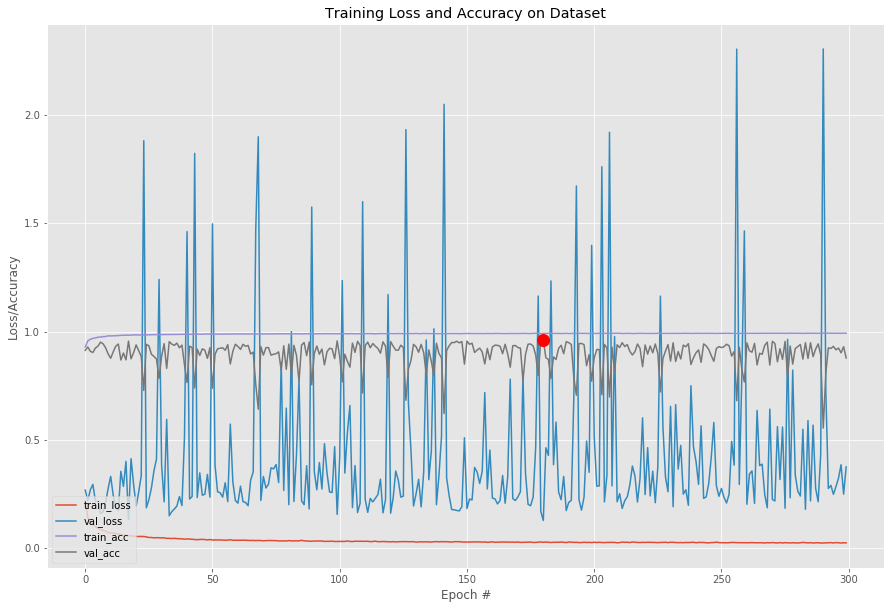

In [34]:
N = NUMBER_OF_EPOCHS
H = trainHistory
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig(TRAIN_EVAL_PLOT_PATH + "/"+ MODEL_NAME +"_Loss_Accuracy.png")

ymax = max(H.history["val_acc"])
xpos = H.history["val_acc"].index(ymax)
print("Best val. Accuracy " + str(H.history["val_acc"][xpos]) + " at Epoch " + str(xpos+1))
plt.plot([xpos],[H.history["val_acc"][xpos]],"ro",markersize=12)
plt.show()

### Sources
- https://www.tensorflow.org/guide/keras
- http://rpg.ifi.uzh.ch/docs/RAL16_Giusti.pdf
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://keras.io/models/sequential/